Using device: cuda:3
Epoch 0, Training Loss: 1.20320e+00, Validation Loss: 1.08653e+00
Epoch 1, Training Loss: 1.09093e+00, Validation Loss: 9.95619e-01
Epoch 2, Training Loss: 9.99729e-01, Validation Loss: 9.24538e-01
Epoch 3, Training Loss: 9.28382e-01, Validation Loss: 8.71315e-01
Epoch 4, Training Loss: 8.74917e-01, Validation Loss: 8.33369e-01
Epoch 5, Training Loss: 8.36748e-01, Validation Loss: 8.07867e-01
Epoch 6, Training Loss: 8.11046e-01, Validation Loss: 7.92120e-01
Epoch 7, Training Loss: 7.95117e-01, Validation Loss: 7.83682e-01
Epoch 8, Training Loss: 7.86517e-01, Validation Loss: 7.80274e-01
Epoch 9, Training Loss: 7.82966e-01, Validation Loss: 7.79760e-01
Epoch 10, Training Loss: 7.82329e-01, Validation Loss: 7.80262e-01
Epoch 11, Training Loss: 7.82726e-01, Validation Loss: 7.80305e-01
Epoch 12, Training Loss: 7.82683e-01, Validation Loss: 7.78926e-01
Epoch 13, Training Loss: 7.81237e-01, Validation Loss: 7.75689e-01
Epoch 14, Training Loss: 7.77950e-01, Validation Lo

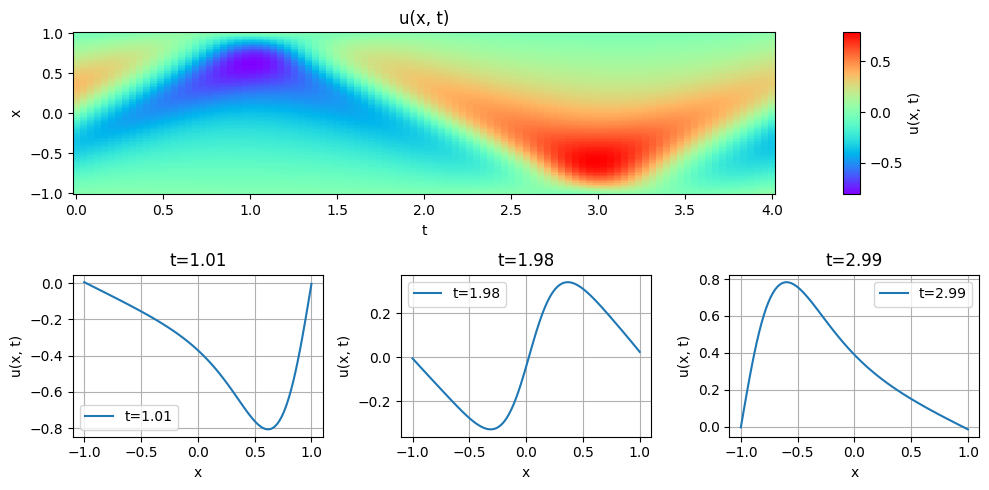

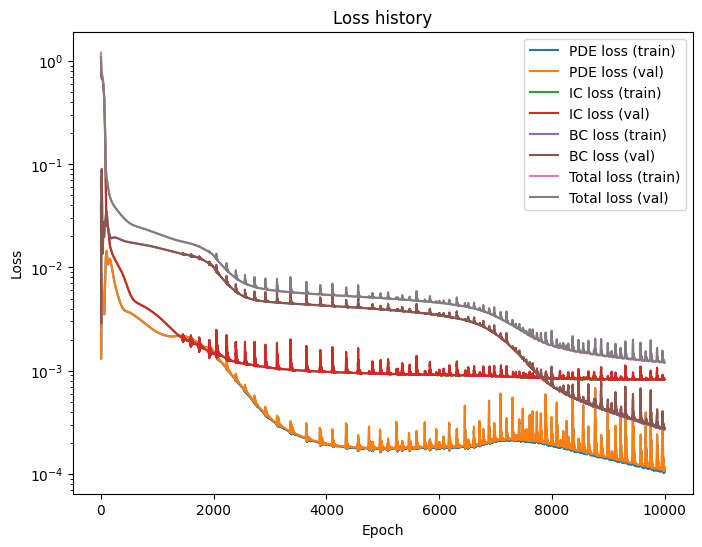

In [ ]:
import statistics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

from src.utils.device_setup import get_device


# Define the neural network model
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        # Initialize weights
        for m in self.layers:
            nn.init.xavier_normal_(m.weight.data, gain=1.0)
            nn.init.zeros_(m.bias.data)

    def forward(self, x):
        y = x
        for i in range(len(self.layers) - 1):
            y = self.activation(self.layers[i](y))
        y = self.layers[-1](y)
        return y


# Define the initial condition u0 and its time derivative
def u0(x, t, c=1, k=2, std=0.5):
    w = c * k
    z = k * x - w * t
    initial_wave = torch.sin(z)
    gaussian_envelope = torch.exp(-((0.5 * z / std) ** 2))
    return initial_wave * gaussian_envelope


def du0_dt(x, t, c=1, k=2, std=0.5):
    w = c * k
    z = k * x - w * t
    initial_wave = torch.sin(z)
    gaussian_envelope = torch.exp(-((0.5 * z / std) ** 2))
    du0_dt_val = -w * torch.cos(
        z
    ) * gaussian_envelope + initial_wave * gaussian_envelope * (
        w * (0.5 / std) ** 2 * z
    )
    return du0_dt_val


# Generate training data
def generate_training_data(num_points, device):
    # Collocation points in the domain
    t_colloc = torch.linspace(0, 4, num_points).to(device)
    x_colloc = torch.linspace(-1, 1, num_points).to(device)
    T_colloc, X_colloc = torch.meshgrid(t_colloc, x_colloc, indexing="ij")
    T_colloc = T_colloc.reshape(-1, 1)
    X_colloc = X_colloc.reshape(-1, 1)
    X_f = torch.cat([T_colloc, X_colloc], dim=1)
    X_f.requires_grad_(True)

    # Initial condition at t=0
    t_i = torch.zeros(num_points, 1).to(device)
    x_i = torch.linspace(-1, 1, num_points).reshape(-1, 1).to(device)
    X_i = torch.cat([t_i, x_i], dim=1)
    X_i.requires_grad_(True)
    u_i = u0(x_i, t_i)

    # Boundary conditions at x=-1 and x=1
    t_b = torch.linspace(0, 4, num_points).reshape(-1, 1).to(device)
    x_b_left = -torch.ones(num_points, 1).to(device)
    x_b_right = torch.ones(num_points, 1).to(device)
    X_b_left = torch.cat([t_b, x_b_left], dim=1)
    X_b_right = torch.cat([t_b, x_b_right], dim=1)
    X_b = torch.cat([X_b_left, X_b_right], dim=0)
    u_b = torch.zeros(X_b.shape[0], 1).to(device)

    return X_f, X_i, u_i, X_b, u_b


# Define the loss function components
def compute_pde_loss(model, X_f, c):
    u = model(X_f)
    u_t = grad(u, X_f, torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_tt = grad(u_t, X_f, torch.ones_like(u_t), create_graph=True)[0][:, 0:1]
    u_x = grad(u, X_f, torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_xx = grad(u_x, X_f, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    residual = u_tt - c**2 * u_xx
    pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual))
    return pde_loss


def compute_ic_loss(model, X_i, u_i):
    u_pred = model(X_i)
    ic_loss = nn.MSELoss()(u_pred, u_i)

    # Time derivative of initial condition
    u_t_pred = grad(u_pred, X_i, torch.ones_like(u_pred), create_graph=True)[0][:, 0:1]
    u_t_true = du0_dt(X_i[:, 1:2], X_i[:, 0:1])
    ic_loss += nn.MSELoss()(u_t_pred, u_t_true)
    return ic_loss


def compute_bc_loss(model, X_b, u_b):
    u_pred = model(X_b)
    bc_loss = nn.MSELoss()(u_pred, u_b)
    return bc_loss


# Training function
def train(model, optimizer, train_set, test_set, c, epochs):
    X_f, X_i, u_i, X_b, u_b = train_set

    X_f_t, X_i_t, u_i_t, X_b_t, u_b_t = test_set

    loss_train_history = {
        "pde_loss": [],
        "ic_loss": [],
        "bc_loss": [],
        "total_loss": [],
    }
    loss_val_history = {
        "pde_loss": [],
        "ic_loss": [],
        "bc_loss": [],
        "total_loss": [],
    }

    model.train()
    for epoch in range(epochs):
        loss_epoch_history = {
            "pde_loss": [],
            "ic_loss": [],
            "bc_loss": [],
            "total_loss": [],
        }

        loss_epoch_val_history = {
            "pde_loss": [],
            "ic_loss": [],
            "bc_loss": [],
            "total_loss": [],
        }

        optimizer.zero_grad()
        # PDE loss
        pde_loss = compute_pde_loss(model, X_f, c)
        # Initial condition loss
        ic_loss = compute_ic_loss(model, X_i, u_i)
        # Boundary condition loss
        bc_loss = compute_bc_loss(model, X_b, u_b)
        # Total loss
        loss = pde_loss + ic_loss + bc_loss

        # Update history
        loss_epoch_history["pde_loss"].append(pde_loss.item())
        loss_epoch_history["ic_loss"].append(ic_loss.item())
        loss_epoch_history["bc_loss"].append(bc_loss.item())
        loss_epoch_history["total_loss"].append(loss.item())

        loss.backward()

        loss_train_history["pde_loss"].append(
            statistics.mean(loss_epoch_history["pde_loss"])
        )
        loss_train_history["ic_loss"].append(
            statistics.mean(loss_epoch_history["ic_loss"])
        )
        loss_train_history["bc_loss"].append(
            statistics.mean(loss_epoch_history["bc_loss"])
        )
        loss_train_history["total_loss"].append(
            statistics.mean(loss_epoch_history["total_loss"])
        )

        optimizer.step()
        loss_value = loss.item()

        # Validation loss
        pde_loss = compute_pde_loss(model, X_f_t, c)
        ic_loss = compute_ic_loss(model, X_i_t, u_i_t)
        bc_loss = compute_bc_loss(model, X_b_t, u_b_t)
        total_loss = pde_loss + ic_loss + bc_loss

        loss_epoch_val_history["pde_loss"].append(pde_loss.item())
        loss_epoch_val_history["ic_loss"].append(ic_loss.item())
        loss_epoch_val_history["bc_loss"].append(bc_loss.item())
        loss_epoch_val_history["total_loss"].append(total_loss.item())

        print(
            f"Epoch {epoch}, Training Loss: {loss_value:.5e}, Validation Loss: {total_loss:.5e}"
        )

        loss_val_history["pde_loss"].append(
            statistics.mean(loss_epoch_val_history["pde_loss"])
        )
        loss_val_history["ic_loss"].append(
            statistics.mean(loss_epoch_val_history["ic_loss"])
        )
        loss_val_history["bc_loss"].append(
            statistics.mean(loss_epoch_val_history["bc_loss"])
        )
        loss_val_history["total_loss"].append(
            statistics.mean(loss_epoch_val_history["total_loss"])
        )

    return loss_train_history, loss_val_history


# Prediction and visualization
def predict(model, num_points, device):
    model.eval()
    t = torch.linspace(0, 4, num_points).to(device)
    x = torch.linspace(-1, 1, num_points).to(device)
    T, X = torch.meshgrid(t, x, indexing="ij")
    T_flat = T.reshape(-1, 1)
    X_flat = X.reshape(-1, 1)
    X_pred = torch.cat([T_flat, X_flat], dim=1)
    with torch.no_grad():
        u_pred = model(X_pred).cpu().numpy().reshape(num_points, num_points)
    return T.cpu().numpy(), X.cpu().numpy(), u_pred


def plot_results(T, X, u_pred):
    from matplotlib.colors import Normalize
    from matplotlib.gridspec import GridSpec

    # Define the range of x and t
    x_min, x_max = -1.0, 1.0  # Adjust based on your domain
    t_min, t_max = 0.0, 4.0  # Adjust based on your time interval

    # Create a grid of x and t values
    num_x = 100  # Number of x points
    num_t = 100  # Number of t points

    x = np.linspace(x_min, x_max, num_x)
    t = np.linspace(t_min, t_max, num_t)
    X, T = np.meshgrid(x, t)

    # Flatten the grid arrays and stack them
    TX = np.stack([T.flatten(), X.flatten()], axis=1)

    # Convert to torch tensor
    TX_tensor = torch.tensor(TX, dtype=torch.float32).to(get_device())
    TX_tensor.requires_grad_(False)

    # Compute u(x, t)
    with torch.no_grad():
        u_pred = model(TX_tensor)
    u_pred = u_pred.detach().cpu().numpy()

    # Reshape u_pred back to grid shape
    U = u_pred.reshape(num_t, num_x)

    # Plot the heatmap
    plt.figure(figsize=(10, 5))
    gs = GridSpec(2, 3)
    plt.subplot(gs[0, :])
    vmin, vmax = U.min(), U.max()
    plt.pcolormesh(
        T, X, U, shading="auto", cmap="rainbow", norm=Normalize(vmin=vmin, vmax=vmax)
    )
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("u(x, t)")
    cbar = plt.colorbar(label="u(x, t)", pad=0.075, aspect=10)
    cbar.mappable.set_clim(vmin, vmax)

    t_cross_section = [1, 2, 3]
    for i, t_val in enumerate(t_cross_section):
        plt.subplot(gs[1, i])
        # Find the index in t closest to t_val
        idx = (np.abs(t - t_val)).argmin()
        x_cross_section = U[idx, :]
        plt.plot(x, x_cross_section, label=f"t={t[idx]:.2f}")
        plt.xlabel("x")
        plt.ylabel("u(x, t)")
        plt.title(f"t={t[idx]:.2f}")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig("wave_result_lbfgs.svg")


def plot_loss_history(history: dict[str, float], label: str):
    plt.figure(figsize=(8, 6))
    plt.plot(history["pde_loss"], label=f"PDE loss ({label})")
    plt.plot(history["ic_loss"], label=f"IC loss ({label})")
    plt.plot(history["bc_loss"], label=f"BC loss ({label})")
    plt.plot(history["total_loss"], label=f"Total loss ({label})")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss history")
    plt.legend()
    plt.show()


# Main execution
if __name__ == "__main__":
    # Device setup
    device = get_device()
    print(f"Using device: {device}")

    # Define wave parameters
    c = 1
    k = 2
    std = 0.5

    # Generate training data
    num_points = 1250
    train_set = generate_training_data(num_points, device)

    # Generate test data
    num_points_test = 200
    test_set = generate_training_data(num_points_test, device)

    # Define model
    layers = [2, 32, 16, 16, 32, 1]
    model = PINN(layers).to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train the model
    epochs = 10000
    loss_train, loss_val = train(
        model,
        optimizer,
        train_set,
        test_set,
        c,
        epochs,
    )

    torch.save(model.state_dict(), "wave_equation_adam.pth")

    # Predict and plot results
    num_test_points = 200
    T, X, u_pred = predict(model, num_test_points, device)
    plot_results(T, X, u_pred)
    plot_loss_history(loss_train, loss_val)

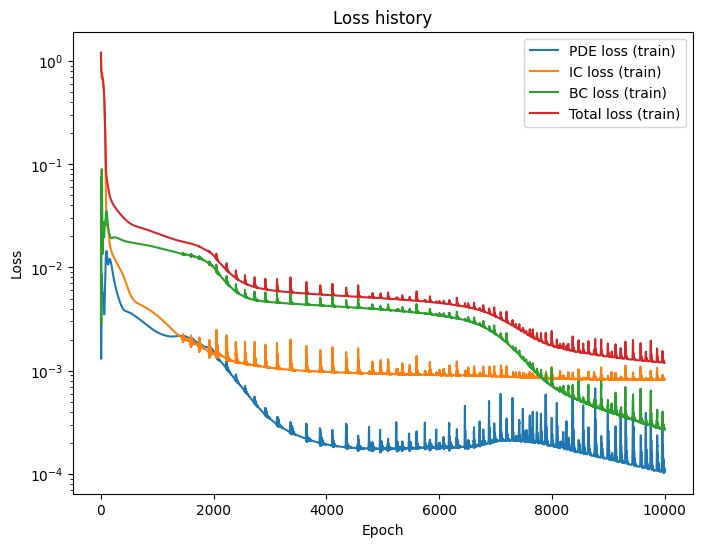

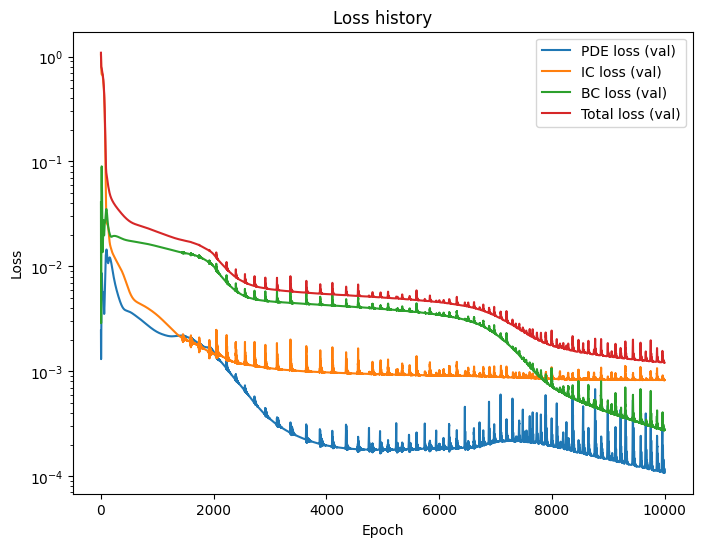

In [4]:
def plot_loss_history(history: dict[str, float], label: str):
    plt.figure(figsize=(8, 6))
    plt.plot(history["pde_loss"], label=f"PDE loss ({label})")
    plt.plot(history["ic_loss"], label=f"IC loss ({label})")
    plt.plot(history["bc_loss"], label=f"BC loss ({label})")
    plt.plot(history["total_loss"], label=f"Total loss ({label})")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss history")
    plt.legend()
    plt.show()


plot_loss_history(loss_train, "train")
plot_loss_history(loss_val, "val")

<img src="./wave_result.svg" />